In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import argparse
import sys
import os
import numpy as np
import glob
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset

from CustomDatasets import MagnetDataset
from Unet_MaxProkop import UNet
from Trainer import Trainer
import functions


In [ ]:
if os.path.exists("../../Stage_magnet"):
    magnetfolder = "../../Stage_magnet"
else:
    magnetfolder = "../Stage_magnet"
    
# if not os.path.exists("../../MagnetDataset.npz"):
#     functions.create_dataset_and_save_to_file(np.sort(glob.glob(magnetfolder+'/Stage1_0*.csv')), magnetfolder)

In [4]:

train_set = MagnetDataset(magnetfolder, (0,0.80),maximum_elements=8960)
val_set = MagnetDataset(magnetfolder, (0.80,1.0),maximum_elements=8960)

train_loader = DataLoader(train_set,batch_size=128, num_workers=os.cpu_count()-2, pin_memory=True)
val_loader = DataLoader(val_set,batch_size=128, num_workers=os.cpu_count()-2, pin_memory=True)

print(train_set[0][0].shape)
print(train_set[0][1].shape)
print(train_set.length)


(4, 120, 80)
(2, 120, 80)
7168


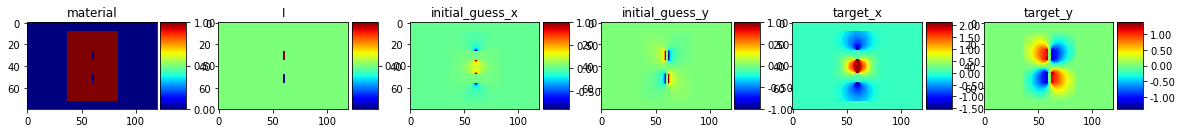

In [5]:
idx = 3
sample=val_set[idx]

fig, axes = plt.subplots(1,6,figsize=(20,4))

for i, name, image in zip(range(6),["material","I","initial_guess_x","initial_guess_y","target_x","target_y"], [sample[0][0,:,:],sample[0][1,:,:],sample[0][2,:,:],sample[0][3,:,:],sample[1][0,:,:],sample[1][1,:,:]]):
    im = axes[i].imshow(image.T, cmap='jet',interpolation='none')
    axes[i].set_title(name)

    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, ticks=MultipleLocator(0.5), format="%.2f")
    

First takeaway: improve initial guess

Split up initial guess into x and y component

In [6]:
#Create model
model = UNet(in_channels=4,out_channels=2,depth=4)

In [7]:
# Select device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.has_mps:
    device = 'mps'
else:
    device = 'cpu'

print(device)

mps


In [8]:
#Create Trainer

trainer_parameters = {
    "optimizer": optim.Adam,
    "optimizer_parameters": {
        "lr":5e-4
    },
    "loss_fun":nn.MSELoss,
    "device":torch.device(device),
    "model":model,
    "train_dataloader":train_loader,
    "val_dataloader":val_loader,
    "num_epochs": 115,
    "priority_mask_mode":"material"
}

trainer = Trainer(**trainer_parameters)

In [9]:
# load trained model to continue training if uncommented
model.load_state_dict(torch.load("last_checkpoint.pth"))

In [10]:
train_hist,val_hist = trainer.train()

	 Epoch 1:	 Train_loss: 0.0806	 Val_loss: 0.0336	21:22:30:33
	 Epoch 2:	 Train_loss: 0.0327	 Val_loss: 0.0331	21:22:33:40
	 Epoch 3:	 Train_loss: 0.0330	 Val_loss: 0.0333	21:22:36:44
	 Epoch 4:	 Train_loss: 0.0335	 Val_loss: 0.0340	21:22:39:49
	 Epoch 5:	 Train_loss: 0.0335	 Val_loss: 0.0339	21:22:42:55
	 Epoch 6:	 Train_loss: 0.0330	 Val_loss: 0.0329	21:22:46:0
	 Epoch 7:	 Train_loss: 0.0321	 Val_loss: 0.0322	21:22:49:4
	 Epoch 8:	 Train_loss: 0.0317	 Val_loss: 0.0313	21:22:52:11
	 Epoch 9:	 Train_loss: 0.0309	 Val_loss: 0.0307	21:22:55:17
	 Epoch 10:	 Train_loss: 0.0304	 Val_loss: 0.0302	21:22:58:23
	 Epoch 11:	 Train_loss: 0.0296	 Val_loss: 0.0284	21:23:1:30
	 Epoch 12:	 Train_loss: 0.0278	 Val_loss: 0.0271	21:23:4:36
	 Epoch 13:	 Train_loss: 0.0264	 Val_loss: 0.0262	21:23:7:40
	 Epoch 14:	 Train_loss: 0.0254	 Val_loss: 0.0252	21:23:10:44
	 Epoch 15:	 Train_loss: 0.0246	 Val_loss: 0.0247	21:23:13:46
	 Epoch 16:	 Train_loss: 0.0240	 Val_loss: 0.0243	21:23:16:51
	 Epoch 17:	 Train_los

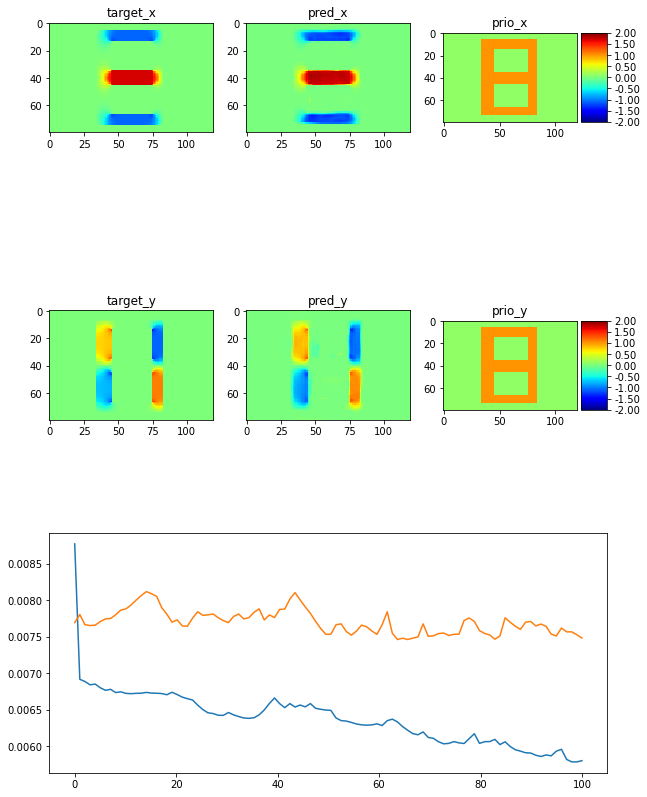

In [ ]:
# model = UNet(in_channels=4,out_channels=2,depth=4)
model.load_state_dict(torch.load("last_checkpoint.pth"))
model.eval()

idx = 258
x,y=train_set[idx]

#x[1,:,:] = np.zeros_like(sample[0][1,:,:])

fig, axes = plt.subplots(3,3,figsize=(10,15))

gs = axes[2, 0].get_gridspec()
axes[2,0].remove()
axes[2,1].remove()
axes[2,2].remove()
axbig = fig.add_subplot(gs[2, 0:])

im0 = axes[0][0].imshow(y[0,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[0][0].set_title("target_x")
im1 = axes[1][0].imshow(y[1,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[1][0].set_title("target_y")

model.to('cpu')
prediction = model(torch.tensor(x).unsqueeze(0).float()).squeeze().detach().numpy() 

im2 = axes[0][1].imshow(prediction[0,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[0][1].set_title("pred_x")
im3 = axes[1][1].imshow(prediction[1,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[1][1].set_title("pred_y")

material_stack = torch.stack([torch.tensor(x)[0,:,:],torch.tensor(x)[0,:,:]],0)
priority_mask = torch.max(torch.ones_like(torch.tensor(y))*0.1,material_stack)


im2 = axes[0][2].imshow(priority_mask[0,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[0][2].set_title("prio_x")
im3 = axes[1][2].imshow(priority_mask[1,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[1][2].set_title("prio_y")

divider = make_axes_locatable(axes[0][2])
cax = divider.append_axes("right", size="20%", pad=0.05)
cbar = plt.colorbar(im1, cax=cax, ticks=MultipleLocator(0.5), format="%.2f")

divider = make_axes_locatable(axes[1][2])
cax = divider.append_axes("right", size="20%", pad=0.05)
cbar = plt.colorbar(im3, cax=cax, ticks=MultipleLocator(0.5), format="%.2f")


x = np.linspace(0, trainer_parameters["num_epochs"], trainer_parameters["num_epochs"])
axbig.plot(x, train_hist)
axbig.plot(x, val_hist)


